In [1]:
# Import all required libraries``
import pandas as pd
from summarytools import dfSummary


# Set pandas options
pd.set_option('future.no_silent_downcasting', True)

### Exploratory Data Analysis

This part of my work mainly focuses on understanding the underlying data and various relationships between different attributes


In [9]:
df = pd.read_csv('data/train_file.csv')
df.sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
10311,46,blue-collar,married,basic.6y,no,no,no,cellular,jul,thu,130,1,0,nonexistent,no
28760,47,technician,married,professional.course,unknown,yes,no,telephone,may,tue,272,3,0,nonexistent,no
6171,48,admin.,married,university.degree,no,yes,yes,cellular,nov,tue,122,1,1,failure,no
27765,54,technician,divorced,university.degree,no,no,no,cellular,aug,tue,155,3,0,nonexistent,no
13044,43,management,married,university.degree,unknown,yes,no,telephone,apr,fri,141,4,0,nonexistent,no


In [10]:
dfSummary(data=df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqJJREFUeJzt3T9v2kAYgPG72olciAzIEWxeGSJ1YPTSb5AP27VbBnYkvoE3JDAgKA7+V12kdmql2DHhXvP89jNW9MiynXtBV1WlANt9ufYJAO/hKotprb8qpe4bLj9XVXVq+ZRwJa7NkQZB8Oz7/qjJ+v1+n2itfxBrN1gbqrmSmkijKDoNBoO0zsLdbufN5/PRer02V2NC7QCbQ31jIh2Px78aLDW3DegI1+J7TL8sy7uWTwlCubbeY2ZZ5hVF8ZSm6YtSqskVFR3i2niPacRxPFoul708z53LnB4kcW29x0yShHtM/MULf4hAqBCBUCECoUIEQoUIhAoRCBUiECpEIFSIQKgQgVAhAqFCBEKFCIQKEawfRWmqKAozHeBrrZsegilWi3Qy1OPxeJdl2bcwDB3HcWpv2jaYYrVLJ0M9n8+u53m92WyWTiaTpO56pljt08lQ/+j3+00nWA0mDCzCwxREIFSIQKgQgVAhAqFCBEKFCIQKEQgVIhAqROj0f6auuKmFDS0tI9QLbGphQ0v7CLXlTS1saLkMQr3MphY2tLSMhymIQKgQgVAhAqFCBEKFCIQKEQgVIhAqRCBUiECoEIFQIQKhQgRChQiEChEIFSIQKkQgVIhAqBCBUNGNmSmttZn/MYNqdfllWZqR45vDqPUnh2oiDYLg2ff9Ud0DZ1nmFUXxlKbpi1Kq6bc+i8Oo9XWuqPcm0iiKToPBoNYfPY7j0XK57OV57qgbwqj1FcelTaR1x4aTJLnpkWFGrdvFwxREIFSIQKgQga/0sQw/jflvhNqxn8bcbrcHrfVPpVTapcjd9742qXvgw+HwtuZ4PHqr1ar3meulfvZms3kwr7am06keDoevDSJ9WCwW38MwfGwS+gcj/6jXqqr++7m/AfUtNx0LVAeCAAAAAElFTkSuQmCC"">",0(0.0%)
2,job[object],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,305 (25.2%)7,430 (22.6%)5,392 (16.4%)3,192 (9.7%)2,343 (7.1%)1,364 (4.1%)1,159 (3.5%)1,098 (3.3%)855 (2.6%)798 (2.4%)974 (3.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9RJREFUeJzt3TFuE0EAhtE1shA0jiJLOUwOwWE5RG4TobggiMZoWiog62+HzXtFhGhw8WmsXc0fDtfrdYHCh+RfAbFREhsZsZERGxmxkREbGbGRERuZw7Isn5dl+bjM6ef1en3d+kOwjuP5fP5yOp3ulwldLpdvh8Phq+D24ThCe3x8fL27u/uxTOTl5eXT09PT/fPz8zh1xbYDx/FjhPbw8PB9mc/4imcnPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvtFaNxd2yZzIyfibc5jtuw45LijHfHxmcbV8O3/hyswwaBzMGvzOK9nmxOsh2bal1lTbVv06yrrKn2b7Z11XRPxKzHS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzbe3+Blhs/AOxq8GLjsm2vhZAxe2N3J5sSiGbwYspAMXgxZqAcvmz/psj0vdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2NjP4MWQhXTwYsjC4Fo4GYMXMh4Q+G++Rn090qyrrKZI1lVWU9TrKqsp/pgHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNuZfV1lNka6rrKb4G66Fk7GuYtqTzUlGM3gxcCEZvBi4UA9eDFz4Z17qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd/gxcCFdPBi4MJbuBZOxuCFKU42pxjN4MW4hWTwYtxCPXgxbmFVXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvbrqssqUjXVZZUrM0GgYx1FZufbE41mnWVZRXJusqyinpdZVnF6rzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiY7vBi7EL6eDF2IVbcC2cjMELGScbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXwskYvJDxgMCmX6O+QmnWVZZVJOsqyyrqdZVlFTfhAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI1t1lWWVaTrKssqbsW1cDLWVWScbGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kXAsnY/BCxn+UxnaDl8HohZsPXsZfGL1QDl4GoxdW56UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREb2wxefv8z3HTwMhi9cAuuhZMxeCHjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjaXyCzy9TuLOK9JUAAAAAElFTkSuQmCC"">",0(0.0%)
3,marital[object],1. married2. single3. divorced4. unknown,"19,929 (60.6%)9,245 (28.1%)3,671 (11.2%)65 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAeFJREFUeJzt28Ft20AURdEZQ3DijQRDgEpIelARKTZFqAj3IBjiIk68YTAdZJNHDP85C29JGBeiKMzr67o2SHiKXAXERlJvrb201p6jV2X4XNf1oxVyOJ/PP47H4+vWN1LNsizvvfeflYI7jNCu1+vH6XT6vfXNVPF4PL7ebrfX+/0+nih1Yht/RmiXy+XX1jdTzEsrxgsCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsZE99TGOvOQuyaPo//swDvGNs1UVj7xsaVmW93FatxXiWPh2Piud0h26KR8pXhCImfExWu7xsxfTrasqrpL2Yqp1VdVV0l7MuK7yE82kvCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2aqKd8s98lOpnwVJ3B7YYNAjCkf032y+bQhs66yeCKyrrJ4Ir2umuJNlm35UZcYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb86yrLJ6IrqssnvgXNgjEWFcR

#### **Initial impressions and take-aways**

#### *Issues and flaws of the original dataset*

<details>

In theory, any dataset can potentially suffer from the following problems that (depending on severity) can seriously limit the ability to make meaninglful prediction:

    - Insufficient sample size
    - Non-representativeness of training data (i.e. sampling bias)    
    - Non-informative features(ex: irrelevant variables, absence of variation)
    - Poor-quality content (ex: ambiguity of values, abundance of outliers and/or missing values)

>Is any of those issues is present in this case? Let's explore it. 

An initial analysis quickly reveals that this dataset contains (at least) the following flaws and inconsistencies that should be adressed:

1. All categorical attributes are stored as objects (i.e. text-data).

2. 8 rows are full duplicates of already existing rows.

3. Although at first glance, there seem to be no missing values, some columns
like ```marital```, ```education```, ```housing``` etc. contain value called *unknown*, which in its essense is equivalent to N/A since it does not provide us any useful meaning on its own. Neither can we regard it as category on its own. 

4. Column ```default``` has almost zero variability (hence, not informative). This is indeed a problem, since only few intances of **yes** are neither sufficient for training data nor for making any meaningful judgements. This handicap therefore makes use of ```default``` column meaningless.

5. Columns ```education``` and ```job``` consists of many categories that despite having the same meaning and describing the same phenomenon, are nevertheless splitted into different categories. I believe this degree of granularity unnecesarily introduces an extra layer of complexity and reduces useful training data size. Yet, it brings no informativeness in practical terms. For instance, does anyone really believe that there is a drastic difference between categories "illeteral", "basic.4y" and "basic.6y"? Is the difference among them really big enough to justify splitting them into different groups? I don't think so. Similarly, don't "blue-collar" and "technician" represent the same job category?

6. Problems, somewhat similar to those described in previous 2 points also exist in some other columns. To name few, columns ```previous```, ```age```, ```duration```, ```month`` etc. all seem to either contain outliers or suffer from scarce presence of certain values.

Ideally, all of those issues should be resolved via taking into consideration the bank's underlying context and cicrumstances under which data was collected. But, given that this kind of information is beyond of my reach, the next best thing I can do is to make plausible assumptions and proceed with them, hoping that my guesses resembly the reality close enough. In the later part of this notebook, I will present my approach.

</details>
















####  *Attributes and their possible meanings*

<details>

| **Column**    | **Column's meaning (*presumably !!!*)** |
|---------------|------------------------|
| age           | Client's current age |
| job           | Job category to which client's profession falls into |
| marital       | Marital Status of a client |
| education     | Level of education that a contacted person has achieved so far |
| default       | Column indicating if this person had credit defaults in the past? |
| housing       | Column indicating whether a client posesses own real estate property? Alternatively, this could also indicate whether a contacted person has an active mortgage loan?|
| loan          | Column indicating whether an individual has any active/remaining loans?|
| contact       | Phone type used for communications ('cellular', 'telephone') |
| month         | Month when contact took place ('jan', 'feb',  ..., 'dec')|
| day_of_week   | Weekday when contact took place |
| duration      | Call duration? (probably in seconds) |
| campaign      | The number of contact attempts made during current campaign? |
| previous      | Number of contact attempts made during previous campgaign?|
| poutcome      | Outcome of the previous marketing campaign? ('success', 'failure', 'other', 'unknown') |
| y             | Target column, indicating whether a given person has agreed to make a deposit |

</details>

In [16]:
cols = ['education', 'job', 'month']

for col in cols:
    print(f'Column: {col}')
    print(df[col].value_counts(normalize=True).round(2)*100)
    print('-' * 10)


Column: education
education
university.degree      30.0
high.school            23.0
basic.9y               15.0
professional.course    13.0
basic.4y               10.0
basic.6y                6.0
unknown                 4.0
illiterate              0.0
Name: proportion, dtype: float64
----------
Column: job
job
admin.           25.0
blue-collar      23.0
technician       16.0
services         10.0
management        7.0
retired           4.0
entrepreneur      4.0
self-employed     3.0
housemaid         3.0
unemployed        2.0
student           2.0
unknown           1.0
Name: proportion, dtype: float64
----------
Column: month
month
may    33.0
jul    17.0
aug    15.0
jun    13.0
nov    10.0
apr     6.0
oct     2.0
sep     1.0
mar     1.0
dec     0.0
Name: proportion, dtype: float64
----------


#### Making data more informative (Data Processing)

NOTE: 
- In order to keep this Notebook neat and tidy, I wrapped all cumbersome code into functions and placed them in a separate Python file called ```custom_functions.py```. Feel free to inspect the source file if you are interested in details of code implementations. 

In [4]:
import custom_functions as cf

> #### Step 1: Data Cleaning

In [18]:
# Replace original values for certain columns
df = df.replace({'unknown': None})

# Impute N/A using relative frequency method instead of dropping them or using KNN imputation
df_imputed = cf.probabilistic_imputation(df)    # Explain why this approach was chosen

# Convert all string columns to categorical
df_imputed = cf.convert_to_categorical(df_imputed, columns='all')

# Drop fully duplicated rows and irrelevant column(s) (which we know exist)
df_imputed = df_imputed.drop_duplicates()
df_imputed = df_imputed.drop(columns=['default'])

> #### Step 2: Making more sense out of features (Feature Engineering)

There are many different combinations of creating columns. Here is my approach.

In [30]:
# Define the mapping for education levels
education_level_mapping = {
    'illiterate': 'low',
    'basic.4y': 'low',
    'basic.6y': 'low',
    'basic.9y': 'low',  
    'high.school': 'mid',
    'professional.course': 'mid',   # This is a guess
    'university.degree': 'high'
}

# Create the education_level column
df_imputed['education_level'] = df_imputed['education'].map(education_level_mapping)

In [31]:
# Define the mapping for job levels
job_category_mapping = {
    'admin.': 'white-collar',
    'blue-collar': 'blue-collar',
    'entrepreneur': 'white-collar',
    'housemaid': 'blue-collar',
    'management': 'white-collar',
    'retired': 'out-of-workforce',
    'self-employed': 'white-collar',
    'services': 'blue-collar',
    'student': 'out-of-workforce',
    'technician': 'blue-collar',
    'unemployed': 'out-of-workforce',
    
}

# Create the job_category column
df_imputed['job_category'] = df_imputed['job'].map(job_category_mapping)

In [37]:
# Define the mapping for job levels based on income level
income_level_mapping = {
    'unemployed': 'low',
    'student': 'low',  
    'retired': 'low', # is it correct? In any case, this would be a guess
    'self-employed': 'mid', # or high?
    'services': 'mid',   
    'technician': 'mid',  
    'housemaid': 'low',
    'blue-collar': 'low',
    'entrepreneur': 'high',    
    'admin.': 'high',
    'management': 'high'  
}
# Create the income_level column
df_imputed['income_level'] = df_imputed['job'].map(income_level_mapping)

In [38]:
dfSummary(data=df_imputed, is_collapsible=True, show_graph=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Missing
1,age[int64],Mean (sd) : 40.0 (10.4)min < med < max:17.0 < 38.0 < 98.0IQR (CV) : 15.0 (3.8),75 distinct values,0(0.0%)
2,job[category],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"8,367 (25.4%)7,492 (22.8%)5,433 (16.5%)3,216 (9.8%)2,360 (7.2%)1,376 (4.2%)1,168 (3.6%)1,111 (3.4%)859 (2.6%)808 (2.5%)711 (2.2%)",0(0.0%)
3,marital[category],1. married2. single3. divorced,"19,960 (60.7%)9,260 (28.1%)3,681 (11.2%)",0(0.0%)
4,education[category],1. university.degree2. high.school3. basic.9y4. professional.course5. basic.4y6. basic.6y7. illiterate,"10,153 (30.9%)7,935 (24.1%)5,017 (15.2%)4,364 (13.3%)3,470 (10.5%)1,946 (5.9%)16 (0.0%)",0(0.0%)
5,housing[category],1. yes2. no,"17,653 (53.7%)15,248 (46.3%)",0(0.0%)
6,loan[category],1. no2. yes,"27,752 (84.4%)5,149 (15.6%)",0(0.0%)
7,contact[category],1. cellular2. telephone,"20,884 (63.5%)12,017 (36.5%)",0(0.0%)
8,month[category],1. may2. jul3. aug4. jun5. nov6. apr7. oct8. sep9. mar10. dec,"10,991 (33.4%)5,751 (17.5%)4,943 (15.0%)4,242 (12.9%)3,262 (9.9%)2,083 (6.3%)586 (1.8%)464 (1.4%)436 (1.3%)143 (0.4%)",0(0.0%)
9,day_of_week[category],1. thu2. mon3. wed4. tue5. fri,"6,845 (20.8%)6,801 (20.7%)6,508 (19.8%)6,436 (19.6%)6,311 (19.2%)",0(0.0%)
10,duration[int64],Mean (sd) : 258.2 (259.1)min < med < max:0.0 < 180.0 < 4918.0IQR (CV) : 216.0 (1.0),"1,467 distinct values",0(0.0%)


c:\Users\user\Projects\Marketing Campaign at Bank\custom_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cat_corr = pd.concat([df_cat_corr, row], ignore_index=True)


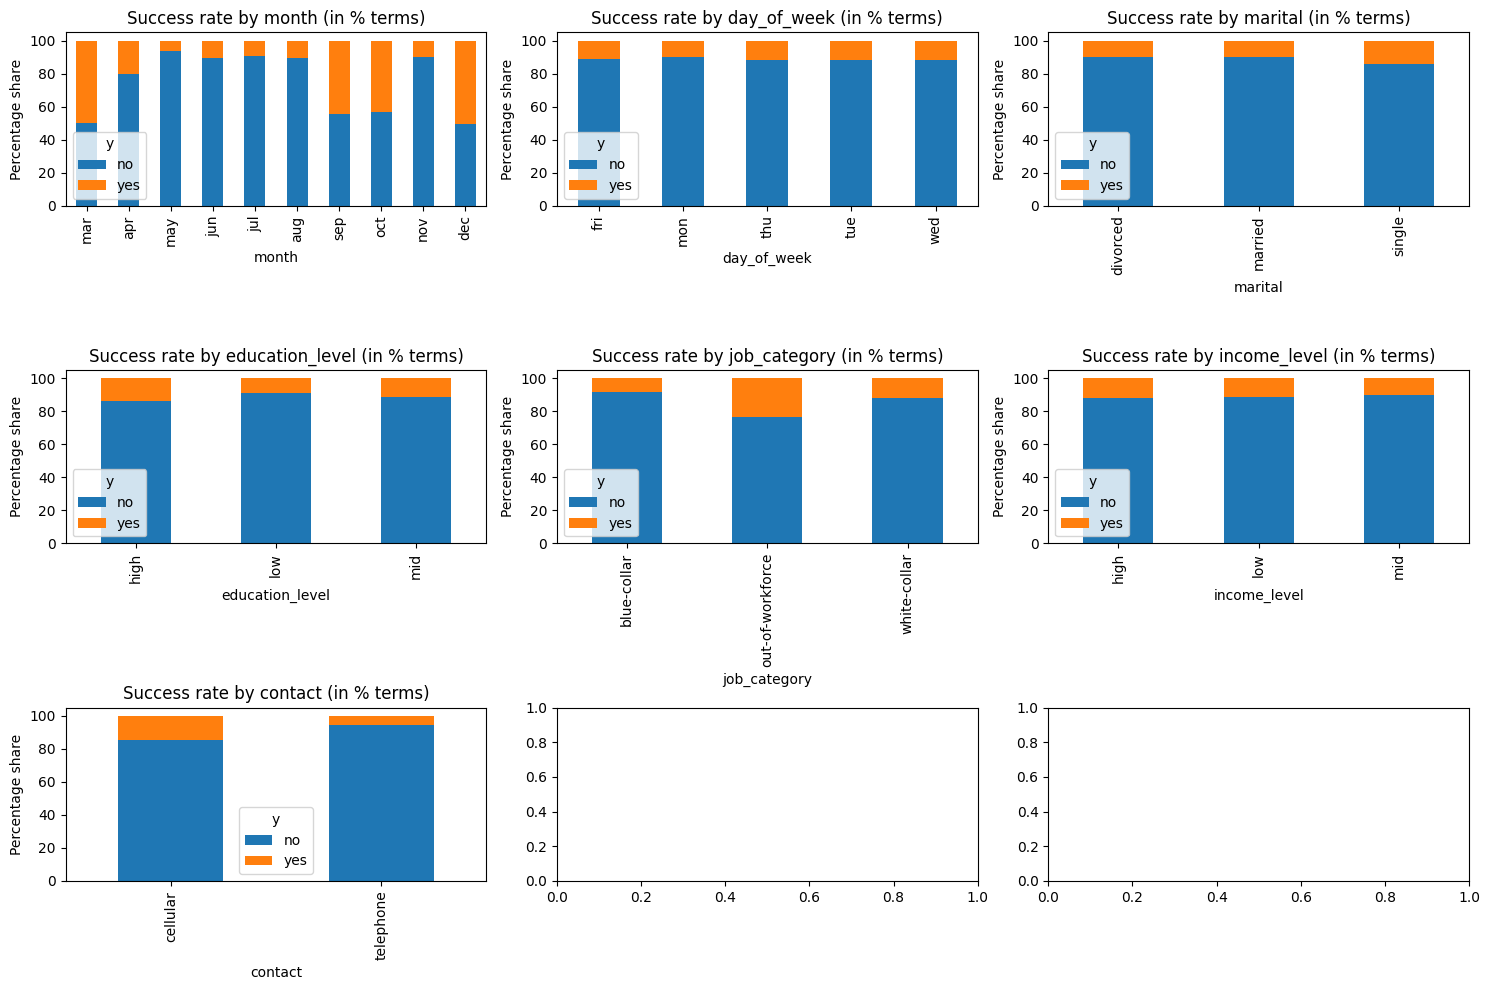

,Column,Chi2,Cramer's V,P-Value,alpha,is_significant
0,month,2457.94,0.27,0.00,0.05,True
1,day_of_week,13.06,0.02,0.01,0.05,True
2,marital,106.90,0.06,0.00,0.05,True
3,education_level,126.74,0.06,0.00,0.05,True
4,job_category,570.40,0.13,0.00,0.05,True
5,income_level,29.09,0.03,0.00,0.05,True
6,contact,673.13,0.14,0.00,0.05,True


In [39]:
# Calculate the correlation between the target variable and categorical variables
cf.show_categorical_correlation(df_imputed,
                                 target='y', 
                                 cols_to_consider=['month', 'day_of_week', 'marital', 'education_level', 'job_category', 'income_level','contact'], 
                                 show_details=False)


In [17]:
df_imputed.groupby('job').aggregate({'age': 'mean'}).round()

C:\Users\user\AppData\Local\Temp\ipykernel_12476\3102520593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_imputed.groupby('job').aggregate({'age': 'mean'}).round()


,age
job,
admin.,38.0
blue-collar,40.0
entrepreneur,42.0
housemaid,45.0
management,42.0
retired,62.0
self-employed,40.0
services,38.0
student,26.0
